## Model 2

### Sprint 4

#### Part 5 

#               <h1><center>Chemical Parameters of the Best Red Wine</center></h1>  


# Table of Content
1. Eploratory data analysis.
2. Statistical inference.
3. Logistics along with other clasified data modeling and testing, as well as linaer Regression modeling and testing.
4. Conclusions.
5. Recomendations

## Introduction

Wine is one the most popular alcoholic baverage in the world. Not only it is popular, it also has very deep history. Some discoveries suggest that this drink can be as old as 5000 BC (https://www.arenaflowers.com/pages/history-of-wine/). There was enough time to make sure that the drink is quality and tasty. 

I will analyze the data set of 1599 different red wines based on their chemical characteristics and quality. The purpose of this analysis is threefold:

1. From the business point of view, I will try to answer what are the key characteristics that make the wine stand out and be of 7 and 8 quality category?

2. I will implement several machine learning models for wine quality guessing. Among many outcomes, I will aim to find out, which model is the best at predicting wine quality.

3. In this project, I will also apply linear regression modeling for analyzing the features that affect quality of the wine and alcohol level. 

The the end of this analysis, I hope to identify what chemical parameters manufacturers should focus aiming for the premium quality wines


### Loading of key libraries

In [72]:
# importing all needed libraries and setting ploting standards

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
pd.options.mode.copy_on_write = True

In [73]:
from IPython.core.display import HTML      # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Exploratory Data Analysis
##### 1.1. Data collection
##### 1.2. Data type
##### 1.3. Missing values
##### 1.4. Data relationship
##### 1.5. Extracting the sample for statistical analysis

#### 1.1. Data collection

In [74]:
data = pd.read_csv("winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Visual distribution of wine quality can be found in the Google Data Studio report:
https://lookerstudio.google.com/s/rj9gaY2dLoU

#### 1.2. Data types

In [75]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

All data is in numeric format, which makes it ready for further analysis.

#### 1.3. Missing values

In [76]:
if data.isnull().values.any():
    result = data.isnull().sum().sum()
else:
    result = 0
print(f'''The size of the dataset is equal to {len(data)} rows and {len(data.columns)} columns. There are
{result} missing values in the data set''')

The size of the dataset is equal to 1599 rows and 12 columns. There are
0 missing values in the data set


#### 1.4. Data relationship

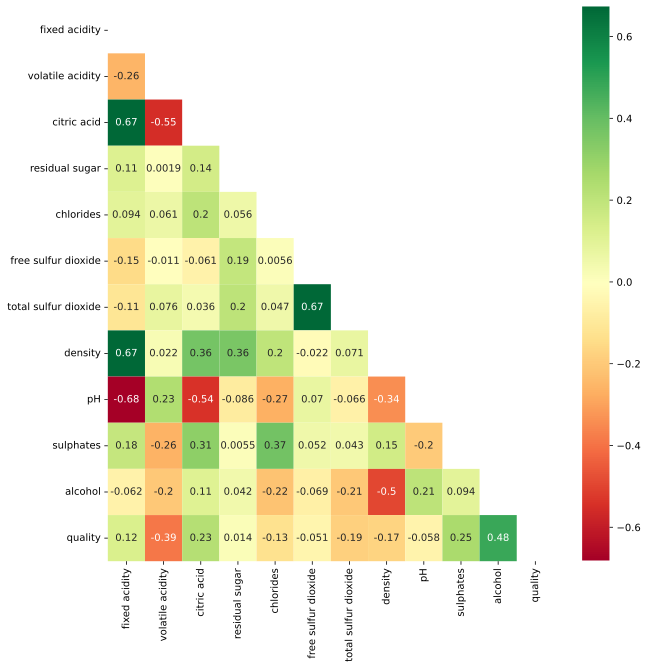

In [77]:
corr = data.corr()
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap = 'RdYlGn', mask = mask)
plt.show()

Our focus of interest is Quality and what features make the wine stand out. Correlation heatmap reveals that quality has moderate positive correlation with the level of alcohol, sulphates and citric acid, and moderate negative relationship with volatile acidity and total sulfur dioxide.

##### 1.4.1 Data distribution

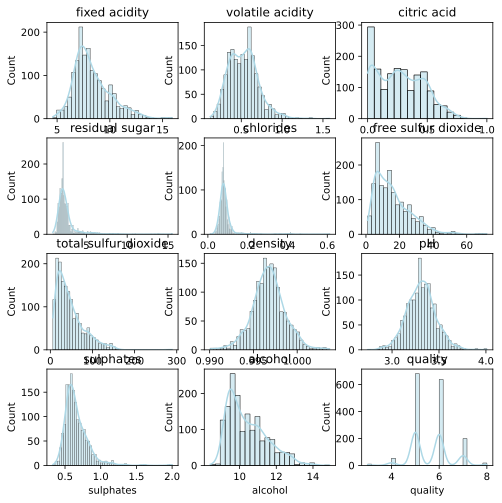

In [78]:
parameters = data.columns.tolist()
num_params = len(parameters)
num_cols = 3
num_rows = math.ceil(num_params / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 8))

for i, param in enumerate(parameters):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(data[param], color='lightblue', kde=True, ax=ax)
    ax.set_title(param)

plt.show()

Data distribution varies across the parameters, but is quite normal. For further analysis, either working with the entire dataset or only with focus group, I will consider the distrubution as normal. 

#### 1.5. Extracting the sample for statistical analysis

In [79]:
focus_group = data[data['quality'].isin([7,8])]
print(f'My focus group equalt to {len(focus_group)/len(data)*100:.1f} % of total data set.')

My focus group equalt to 13.6 % of total data set.


## 2. Statistical Inference
The target population for statistical analysis is the wine group of quality rating 7 and 8. This group equals to 13.6 % of the total data set and makes the nice sample with 217 representatives for further analysis. I will call this group 'best wines'. The other group (ratings 3-6) will be called 'regular wines'.

In correlation analysis, we have discovered that there is moderate positive correlation with the level of alcohol, sulphates and citric acid, and moderate negative relationship with density, volatile acidity, and total sulfur dioxide. I choose these parameters for statistical analysis. 
##### <br> **Research question:** comparing the key chemical parameter (alcohol, sulphates and citric acid, density, volatile acidity, and total sulfur dioxide) of wine are these parameters' means significantly different between the best and the regular wines.  

##### <br> **Null Hypothesis:** there is not statistically significant difference between the best and regular wines in terms of key quality characteristics means.

##### <br>**Alternative Hypothesis:** Key quality characteristics means for the best wine differ significantly from the regular wine group.

##### <br>**Confidence level:** 95%

#### 2.1. Data frame of means and then filtering out the unecesary parameters

In [80]:
quality_means = data.groupby('quality').mean()
melted_df = quality_means.reset_index().melt(id_vars="quality", var_name="feature", 
                                             value_name="mean_value")
focus_parameters = ['alcohol', 'sulphates', 'citric acid', 'density', 
                    'volatile acidity','total sulfur dioxide']
focus_data = melted_df[melted_df['feature'].isin(focus_parameters)]

#### 2.2. Two data frames 'best_wines' and 'regular_wines' for further statistical analysis

In [81]:
best_wines = focus_data[focus_data['quality'].isin([7,8])]
best_wines_grouped = best_wines.groupby('feature')['mean_value'].mean().reset_index()
regular_wines = focus_data[focus_data['quality'].isin([3,4,5,6])]
reg_wines_grouped = regular_wines.groupby('feature')['mean_value'].mean().reset_index()

#### 2.3. T-test on the means of the best and regular wines on selected parameters

In [82]:
results = []
param_names = best_wines_grouped['feature'].unique()

for param in param_names:
    best_wines_means = best_wines[best_wines['feature']==param]['mean_value'].tolist()
    reg_wines_means = regular_wines[regular_wines['feature']==param]['mean_value'].tolist()
    t, p = ttest_ind(best_wines_means, reg_wines_means)
    mean_diff = np.mean(best_wines_means) - np.mean(reg_wines_means)
    std_err = np.sqrt(np.var(best_wines_means, ddof=1)/len(best_wines_means) 
                      + np.var(reg_wines_means, ddof=1)/len(reg_wines_means))
    lower_bound = mean_diff - 1.96 * std_err
    upper_bound = mean_diff + 1.96 * std_err
    t = round(t, 3)
    p = round(p, 5)
    lower_bound = round(lower_bound, 3)
    upper_bound = round(upper_bound, 3)
    result = {'parameter':param, 't-stat':t, 'p-value':p, 'lower_bound':lower_bound, 
             'upper_bound':upper_bound}
    results.append(result)
t_test_results = pd.DataFrame(results)
t_test_results

,parameter,t-stat,p-value,lower_bound,upper_bound
0,alcohol,5.025,0.00736,0.894,2.291
1,citric acid,4.321,0.01244,0.115,0.220
2,density,-2.997,0.04008,-0.002,-0.000
3,sulphates,4.009,0.01601,0.088,0.190
4,total sulfur dioxide,-0.549,0.61231,-18.333,7.533
5,volatile acidity,-1.977,0.11916,-0.415,-0.084


Statistical test generally supported the correlation suggestions. Out of 6 chosen parameters, 4 have a clear support for alternative hypothsis. Total sulfur dioxide p-value is way higher than our confidence level, which is supported by the confidence interval having 0 within. However, volatile acidity parameter remains interesting to me, even though p value is above our confidence level. Confidence interval for this parameter does not include 0. I will perform the visual analysis of means later before including or excluding this parameter from the key ones for quality.

#### 2.4. T-test on the means of the best and regular wines on all parameters
Although correlation analysis clearly distinguished those chemical parameters that correlate with quality, for the sake of surety, I will additionally perform t-test of the chosen groups data on all parameters. This test should show what p-values of all the parameters are, and how they compare to the chosen confidence level. 

For this test I will create two new dataframes with all the chemical parameters divided into two groups according to the quality rating.

In [83]:
# Creating dataframes
best_wines_all = data[data['quality'].isin([7,8])]
regular_wines_all = data[data['quality'].isin([3,4,5,6])]
best_wines_all.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
16,8.5,0.28,0.56,1.8,0.092,35.0,103.0,0.9969,3.30,0.75,10.5,7
37,8.1,0.38,0.28,2.1,0.066,13.0,30.0,0.9968,3.23,0.73,9.7,7
62,7.5,0.52,0.16,1.9,0.085,12.0,35.0,0.9968,3.38,0.62,9.5,7


In [84]:
# t-test onl entire data set
best_wines_all = melted_df[melted_df['quality'].isin([7,8])]
best_wines_all_grouped = best_wines_all.groupby('feature')['mean_value'].mean().reset_index()
regular_wines_all = melted_df[melted_df['quality'].isin([3,4,5,6])]
reg_wines_all_grouped = regular_wines_all.groupby('feature')['mean_value'].mean().reset_index()

results = []
param_names = best_wines_all_grouped['feature'].unique()

for param in param_names:
    best_wines_means_a = best_wines_all[best_wines_all['feature']==param]['mean_value'].tolist()
    reg_wines_means_a = regular_wines_all[regular_wines_all['feature']==param]['mean_value'].tolist()
    t, p = ttest_ind(best_wines_means_a, reg_wines_means_a)
    mean_diff = np.mean(best_wines_means_a) - np.mean(reg_wines_means_a)
    std_err = np.sqrt(np.var(best_wines_means_a, ddof=1)/len(best_wines_means_a) 
                      + np.var(reg_wines_means_a, ddof=1)/len(reg_wines_means_a))
    lower_bound = mean_diff - 1.96 * std_err
    upper_bound = mean_diff + 1.96 * std_err
    t = round(t, 3)
    p = round(p, 5)
    lower_bound = round(lower_bound, 3)
    upper_bound = round(upper_bound, 3)
    result = {'parameter':param, 't-stat':t, 'p-value':p, 'lower_bound':lower_bound, 
             'upper_bound':upper_bound}
    results.append(result)
t_test_results = pd.DataFrame(results)
t_test_results

,parameter,t-stat,p-value,lower_bound,upper_bound
0,alcohol,5.025,0.00736,0.894,2.291
1,chlorides,-1.957,0.12199,-0.044,-0.007
2,citric acid,4.321,0.01244,0.115,0.220
3,density,-2.997,0.04008,-0.002,-0.000
4,fixed acidity,2.487,0.06773,0.156,0.956
5,free sulfur dioxide,-0.154,0.88480,-3.192,2.535
6,pH,-2.033,0.11178,-0.122,-0.021
7,residual sugar,0.760,0.48958,-0.105,0.235
8,sulphates,4.009,0.01601,0.088,0.190
9,total sulfur dioxide,-0.549,0.61231,-18.333,7.533


 ##### Prepare data for Google data visual studio

In [85]:
t_test_result_conf = t_test_results[['parameter', 'p-value']]
t_test_result_conf['confidence'] = 0.05
t_test_result_conf.to_csv('t_test.csv', index=False)

For the visual of P-values against confidence level, please follow the link to the Google Data Studio:
https://lookerstudio.google.com/s/g4EecKLT0t0

The t-test result shows that p-values for four chemical parameters - alcohol, citric acid, density, and suphates are bellow our significance level 0.05 and suggests that we can reject the Null Hypothesis regarding parameter means being insignificant. 

On the other hand, total sulfur dioxide and volatile acidity have p-values higher than 0.05 and for these parameters Null Hypothesis should be accepted. However, the confidence interval for volatile acidity does not include 0, which suggests that the parameter is significatly different from zero for the chosen confidence level and that the observed difference is statistically significant.

Other than statistical test, visually observing the means for volatile acidity also suggest that this parameter is important for the quality of wine. To ilustrate this, I will draw a combined plot comparing the means of different categories against the overall mean.

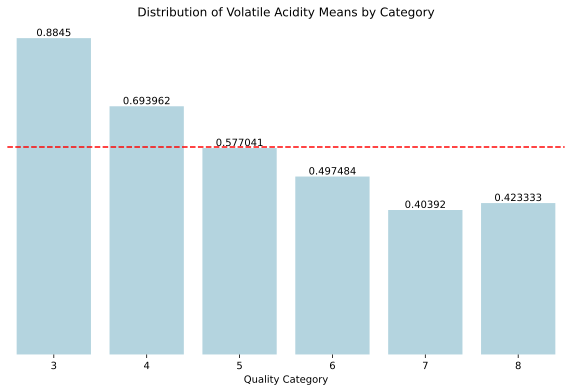

In [86]:
v_acid_data = focus_data[focus_data['feature']=='volatile acidity']
v_acid_mean = v_acid_data['mean_value'].mean()

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='quality', y='mean_value', data=v_acid_data, errorbar=None, ax=ax, color = 'lightblue')
plt.axhline(y=v_acid_mean, color='red', linestyle='--')
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, left=True, bottom=True)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Quality Category')
plt.title('Distribution of Volatile Acidity Means by Category')
plt.show()

#### Conclusion on Statistical Inference
For the volatile acidity, both, confidence interval and visual observation suggest that this parameter is significant for the quality rating. Thus, I will keep it as an important feature for the futher analysis and modeling. One of the reasons why p-value is above my significance level is becuase wine category 8 has higher volatile acidity than that of 7.

To sum up, statistical analysis helped distinguishing 5 chemical features that seem to be important for quality of the wine. Next, I will perform machine leaning modeling to the asumptions on these parameters.

## 3. Predicting Wine Quality Modeling

Now, as we have identified chemical features that have an effect on wine quality, I will apply machine learning models to predict the quality column. Since statistical analysis showed that only 5 chemical features have a significant enough effect on the quality of wine, I will train the models based on these five features. On the other hand, just as with t-test, I will perform the modeling on all parameters as well.


Predicting wine quality will involve the following steps:

1. Selecting and training the models and evaluating them with accuracy, precision, recall and F1-score tests.
2. Perform linear regression modeling on entire data set predicting the quality and the alcohol value of wine based on 11 other features, including R-squared analysis and information criteria.

#### 3.1. Selecting and evaluating the models

My main research question is "what are the key characteristics that make the wine stand out and be of 7 and 8 quality category" - I have divided the data set of wines into two categories - 'best' and 'regular' wines. So to predict if the wine belongs to one or the other category I need to use logistics regression. Thus I will create a new dataframe with all the categories, 5 significant features, and the group ID - 1 being 'best' and 0 being 'regular' wines.  

In addition to logistic regression, I will also test decision tree and random forest models, which are also serve as a good alternatives for classified analysis. Using three different models should help me identify, which one of them shows the best result at predicting the wine quality.

##### 3.1.1. Adjust data set for modeling

In [87]:
mod_data = data
important_parameters = ['alcohol', 'sulphates', 'citric acid', 'density', 'volatile acidity', 
                        'quality', 'group']
mod_data['group'] = mod_data['quality'].apply(lambda x: 1 if x in[7,8] else 0)
selected_data = mod_data[important_parameters]

##### 3.1.2. Training and testing the models

In [88]:
datasets = {'All parameters': mod_data,
           'Selected parameters': selected_data}

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}
results = []
for dataset_name, dataset in datasets.items():
    X = dataset.drop(['quality', 'group'], axis=1)
    y = dataset['group']
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        accuracy = round(accuracy_score(y_test, y_predict),2)
        precision = round(precision_score(y_test, y_predict),2)
        recall = round(recall_score(y_test, y_predict),2)
        f1 = round(f1_score(y_test, y_predict),2)
    
        results.append({'Dataset': dataset_name,'Model': model_name,'Accuracy': accuracy,
                        'Precision': precision,'Recall': recall,'F1-score': f1})    

In [89]:
results_df = pd.DataFrame(results)
results_df.to_csv('results_df.csv', index = False )
results_df

,Dataset,Model,Accuracy,Precision,Recall,F1-score
0,All parameters,Logistic Regression,0.87,0.62,0.21,0.32
1,All parameters,Decision Tree,0.89,0.63,0.55,0.59
2,All parameters,Random Forest,0.90,0.72,0.55,0.63
3,Selected parameters,Logistic Regression,0.86,0.55,0.23,0.33
4,Selected parameters,Decision Tree,0.87,0.55,0.55,0.55
5,Selected parameters,Random Forest,0.90,0.67,0.62,0.64


##### 3.1.3. Results of clasification modeling analysis


1. **Accuracy.** All options have relatively high test accuracy - meaning that models coretly clasified wine wither as 'best' or as 'regular' by ~ 90% of the time. However, Random Forest model for both datasets showed the best accuracy.
2. **Precision.** The variability of precision is higher. Again, Random Forest model has the highest precision - meaning that about 68 % of predictions were done correctly.
3. **Recall.** The higher the value the better, indicating that the model correctly identifies the samples. Selected parameters Random Forest has the highest recall value.
4. **F1-score.** This measure indicates a trade-off between precision and recall. As expected, the higher the value, the better is the model. Selected parameters Random Forest has the best value in this test as well.

Concluding model selection part, selected parameters Random Forest model displayed the best results.

For a visual analysis in Google Data Studio, please follow the link:
https://lookerstudio.google.com/s/qOkOo99tAr4

#### 3.2. Linear regression modeling for entire dataset to predict the quality and alcohol value of the wine.

I will perform linear regression analysis on all parameter and selected parameter data sets. The goal of this analysis is to test the predition of quality and alcohol level based on other parameters.

In [90]:
important_parameters = ['alcohol', 'sulphates', 'citric acid', 'density', 'volatile acidity', 
                        'quality', 'group']
selected_data = data[important_parameters]
datasets = {'All parameters': data,
           'Selected parameters': selected_data}
test_params = {'Quality':'quality', 'Alcohol':'alcohol'}
results2 = []
for dataset_name, dataset in datasets.items():
    for param_name, param in test_params.items():
        X = dataset.drop([param], axis=1)
        y = dataset[param]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        linear_reg = LinearRegression()
        linear_reg.fit(X_train, y_train)
        y_predict = linear_reg.predict(X_test)
        r2 = round(r2_score(y_test, y_predict), 2)
        mse = round(mean_squared_error(y_test, y_predict), 2)
        rmse = round(np.sqrt(mse), 2)
        mae = round(mean_absolute_error(y_test, y_predict), 2)
        
        # Adjusted R-squared calculation
        n = X_test.shape[0]
        p = X_test.shape[1]
        adj_r2 = round(1 - ((1 - r2) * (n - 1)) / (n - p - 1), 2)
        
        rss = np.sum(np.square(y_test - y_predict))
        aic = round(n * np.log(rss / n) + 2 * (p + 1), 2)
        bic = round(n * np.log(rss / n) + (p + 1) * np.log(n), 2)
        
        results2.append({'Dataset': dataset_name,'Parameter': param_name,'R-squared': r2,
                        'Adjusted R-squared': adj_r2,'Mean Squared Error (MSE)': mse,
                        'Root Mean Squared Error (RMSE)': rmse,'Mean Absolute Error (MAE)': mae,
                        'AIC': aic,'BIC': bic})

In [91]:
results2_df = pd.DataFrame(results2)
results2_df

,Dataset,Parameter,R-squared,Adjusted R-squared,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),AIC,BIC
0,All parameters,Quality,0.63,0.62,0.24,0.49,0.40,-428.89,-379.91
1,All parameters,Alcohol,0.72,0.71,0.35,0.59,0.45,-314.49,-265.51
2,Selected parameters,Quality,0.63,0.62,0.24,0.49,0.41,-442.73,-416.35
3,Selected parameters,Alcohol,0.51,0.50,0.61,0.78,0.62,-143.37,-116.99


#### Analysis of Linear regression results

1. R-squared metric indicates the proportion of the variance in the quality and alcohol variables. The closer the value is to 1, the better is the model fit. From the results we see that selected parameters and all parameter quality prediction is the same, which indicates that selected parameters are in fact the ones that have affect on the quality of the wine. Predicting alcohol level apparently all parameters are important. Adjusted R-squared, consideres the complexity of the model and penalizes the addition of irrelevant parameters. However, the adjusted R2 reduced the reliability of the model very little. 
2. Error measures:

 2.1. Mean Squared Error (MSE) measures the average squared difference between the predicted and actual values, which best if it is lower. From the result we see that quality predictions are the same for both datasets, while selected parameters fail to predict alcohol level acuratelly. 
 
 2.2. Root Mean Squared Error (RMSE) - the lower the better. Same conlusion as for 2.1.
 
 2.3. Mean Absolute Error (MAE) measures absolute difference between the predicted and the actual values. It is less sensitive to the outliers. The lower the value the better. Same conlusion as for 2.1.

3. Complexity and fit trade-off parameters:

 3.1. Akaike Information Criterion (AIC) measures the trade-off between model fit and complexity by penalizing addition of many parameters. The lower the value the better.
 
 3.2. Bayesien Information Criterion (AIC) measures the trade-off between model fit and complexity by puting stronger penalty on addition of many parameters. The lower the value the better.
 
 3.3. Both criteria improves if increaseing the training proportion. We can see that the selected parameters quality test has the lowest value, which in turn supports the selection of these parameters. 

## 4. Conclusion

The goal of the project was to identify, which chemical parameters make the wine be considered as the best. For the best wines, I chose quality category 7 and 8. The following findings were discovered:

1. Statistical analysis helped identify, which chemical parameters in fact affect the quality of the wine. Five parameters were chosen - alcohol, sulphates, citric acid, density, and volatile acidity. Alcohol, suphates, and cistric acid has positive correlation with the wine quality. Thus manufacturers should focus on making sure that these particular parameters of their wine production should corespond to the quality standards that they aim for. On the other hand, manufacturers should seek to minimize the density and volatile acidity.
2. Machine learning models proved that chosen parameters help predict wine quality. Random forest model on the selected parameters proved the highest accuracy on prediction. 
3. Linear regression modeling supported the conclusions that selected parameters are in fact well chosen and that they can help predict the quality of wine.

The project identified the chemical parameters for the wine makers to focus if they seek to create the best quality wines. Different machine learning models proved that selected parameters were well chosen. 


## 5. Recomendations
While manufacturing the best wines could be a nice purpose, it is likely that regular wines have a higher market demand. For further research, the focus on the 4, 5, and 6 quality rating can be performed. This analysis could also provide some additional insights for wine makers.